In [1]:
# Import packages.
import numpy as np
import matplotlib.pyplot as plt
import qctrlvisualizer
import boulderopal as bo
import qutip as qt
import scipy.special as sp
import qctrlvisualizer as qv
import jsonpickle



In [26]:
def load_variable(file_name):
    """
    Load a variable from a file encoded with jsonpickle.
    """
    with open(file_name, "r+") as file:
        return jsonpickle.decode(file.read())
waveform_path = "./"
fname = "pi2_40ns_1"
optimization_result= load_variable(waveform_path+fname)

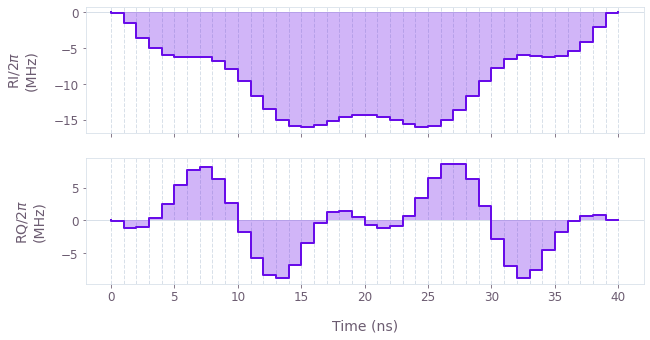

In [27]:

qv.plot_controls(
    {
        "RI": optimization_result["output"]["$\\Omega L(\\I)$"],
        "RQ": optimization_result["output"]["$\\Omega L(\\Q)$"],
    },
    polar=False,
)

In [46]:
def dev_gaussian_env(t, sigma, chop, rot_angle, ti):  
    tg = chop * sigma
    tf = ti + tg
    amp = rot_angle / (np.sqrt(2*np.pi)*sigma*sp.erf(tg/(2*np.sqrt(2)*sigma)) - np.exp(-(tg/2)**2/(2*sigma**2))*tg)
    return (- amp * (t-ti-tg/2)/(sigma**2) * np.exp(-(t-ti-tg/2)**2/(2*sigma**2)) ) * np.heaviside(t - ti, 0) * np.heaviside(tf - t, 0)
def gaussian_env(t, sigma, chop, rot_angle, ti):  
    tg = chop * sigma
    tf = ti + tg
    amp = rot_angle / (np.sqrt(2*np.pi)*sigma*sp.erf(tg/(2*np.sqrt(2)*sigma)) - np.exp(-(tg/2)**2/(2*sigma**2))*tg)
    offset = amp * np.exp(-(tg/2)**2/(2*sigma**2))
    return (amp * np.exp(-(t-ti-tg/2)**2/(2*sigma**2)) - offset) * np.heaviside(t - ti, 0) * np.heaviside(tf - t, 0)

def Rx(matrix,angle):
    matrix[0,0]=np.cos(angle/2)
    matrix[0,1]=-1j*np.sin(angle/2)
    matrix[1,0]=-1j*np.sin(angle/2)
    matrix[1,1]=np.cos(angle/2)
    return matrix
from qutip import *
def simulation(anh, segment_count, optimization_result, realized_gate):
    import qutip as qt

    import scipy.special as sp
    total_time = segment_count
    total_time_steps = segment_count
    k_q = anh/1e9
    controlI = []
    durations = optimization_result["output"]["$\\Omega L(\\I)$"]['durations']
    results = optimization_result["output"]["$\\Omega L(\\I)$"]['values']
    for i in range(len(durations)):
        if durations[i]>1e-15:
            controlI.append(results[i]/1e9)
    controlI = np.array(controlI)
    controlQ = []
    durations = optimization_result["output"]["$\\Omega L(\\Q)$"]['durations']
    results = optimization_result["output"]["$\\Omega L(\Q)$"]['values']
    for i in range(len(durations)):
        if durations[i]>1e-15:
            controlQ.append(results[i]/1e9)
    controlQ = np.array(controlQ)
    pulse=[controlI,controlQ]



    # Qutip will do interpolation for drive, which distort piece-wise-constant control. 
    # Here I manually do interpolation to make sure piece-wise-constant pulse.
    resolution = 1
    times = np.linspace(0, total_time, total_time_steps*resolution+1)
    times=np.delete(times, [len(times) - 1])
    best_controls=np.zeros_like(np.array([times,times]))
    for m in range(len(best_controls)):
        for i in range(len(pulse[0])): 
            for j in range(resolution):
                best_controls[m][i*resolution+j]=pulse[m][i]*(1)
            
    angle = np.pi
    N_q = 5
    target_states=np.zeros([N_q,N_q],dtype=complex)
    target_states=Rx(target_states,angle)
    U_ideal=qt.Qobj(target_states)

    a_q = destroy(N_q)
    n_q = a_q.dag() * a_q
    x_q = a_q + a_q.dag()
    cross = 0e-3 * 2*np.pi
    # without -1/2, strange result when change time origin
    H0 =  1/2*k_q * a_q.dag()**2 * a_q**2
    Hcx=a_q+a_q.dag()
    Hcy=-a_q*1j+1j*a_q.dag()
    H0=H0.full()
    Hcx=Hcx.full()
    Hcy=Hcy.full()
    H_controls=[Hcx,Hcy]

    #infidelity withought fluctuation
    import qutip as qt
    qt_H0=qt.Qobj(H0)
    qt_Hcx=qt.Qobj(H_controls[0])
    qt_Hcy=qt.Qobj(H_controls[1])
    qt_tlist=times
    options = qt.Options()
    options["atol"] = 1e-10


    fluc_oper=n_q
    fluc = np.linspace(-0.03,0.03,40)*2*np.pi
    infidelities=np.zeros(len(fluc))
    infidelities_gau=np.zeros(len(fluc))

    pp=np.zeros(len(fluc))
    pp_gau=np.zeros(len(fluc))

    U_ideal=qt.Qobj(target_states)
    for i in range(len(fluc)):
        qt_H0=qt.Qobj(H0)
        qt_H0=qt_H0+fluc[i]*fluc_oper

        qt_cx = best_controls[0]
        qt_cy = best_controls[1]
        qt_cx_coe = coefficient(qt_cx,tlist=qt_tlist)
        qt_cy_coe = coefficient(qt_cy,tlist=qt_tlist)
        qt_H = qt.QobjEvo([qt_H0, [qt_Hcx, qt_cx_coe], [qt_Hcy, qt_cy_coe]])
        output = qt.propagator(qt_H, qt_tlist, options=options)
        if realized_gate == "x/2":
            output = output[-1]*output[-1]
        else:
            output = output[-1]
        infidelities[i] = 1 - np.abs(np.trace(U_ideal.full() @ output.dag().full()))**2 / 4
        pp[i] = np.abs((output.full())[1,0])**2

        chop=4
        sigma=segment_count/chop
        if realized_gate == "x/2":
            rot_angle=angle/2
        else:
            rot_angle=angle
        qt_cx = gaussian_env(qt_tlist, sigma, chop, rot_angle, 0)/2
        qt_cy = -0*dev_gaussian_env(qt_tlist, sigma, chop, rot_angle, 0)/ (4*k_q) 
        qt_cx_coe = coefficient(qt_cx,tlist=qt_tlist)
        qt_cy_coe = coefficient(qt_cy,tlist=qt_tlist)
        qt_H = qt.QobjEvo([qt_H0, [qt_Hcx, qt_cx_coe], [qt_Hcy, qt_cy_coe]])
        output = qt.propagator(qt_H, qt_tlist, options=options)
        if realized_gate == "x/2":
            output = output[-1]*output[-1]
        else:
            output = output[-1]
        infidelities_gau[i] = 1 - np.abs(np.trace(U_ideal.full() @ output.dag().full()))**2 / 4
        pp_gau[i] = np.abs((output.full())[1,0])**2

    return fluc, infidelities, infidelities_gau, pp, pp_gau


In [47]:
anh = -2 * np.pi * 245.3844e6
duration = segment_count = 40
# realized_gate = "x"
realized_gate = "x/2"
fluc, infidelities, infidelities_gau, pp, pp_gau = simulation(anh, segment_count, optimization_result, realized_gate)

c:\Users\17732\anaconda3\lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


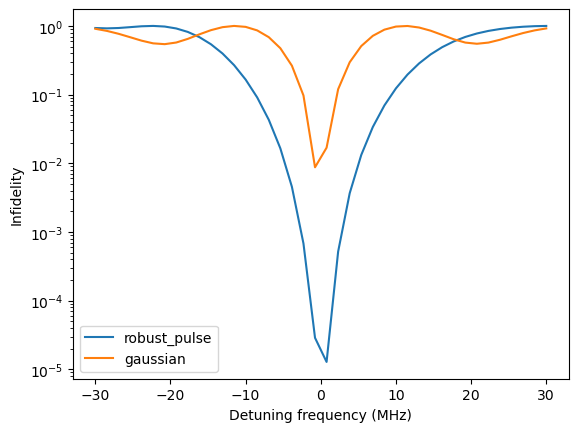

In [48]:
fig,ax=plt.subplots()
ax.plot(fluc/(2*np.pi)*1e3,infidelities,label = 'robust_pulse')
ax.plot(fluc/(2*np.pi)*1e3,infidelities_gau, label = 'gaussian')
ax.set_xlabel('Detuning frequency (MHz)')
ax.set_ylabel('Infidelity')
plt.legend()
ax.set_yscale('log')

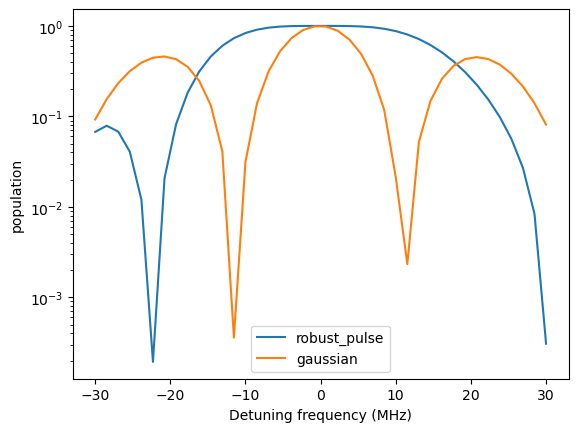

In [51]:
fig,ax=plt.subplots()
ax.plot(fluc/(2*np.pi)*1e3,pp, label = 'robust_pulse')
ax.plot(fluc/(2*np.pi)*1e3,pp_gau,label = 'gaussian')
ax.set_xlabel('Detuning frequency (MHz)')
ax.set_ylabel('population')
plt.legend()
ax.set_yscale('log')